In [1]:
import numpy as np
import xarray as xr
import xesmf as xe
import matplotlib.pyplot as plt
import glob
from utils import *

In [2]:
client=get_cluster(50)

In [380]:
import joblib
from joblib import Parallel,delayed

In [3]:
def get_avgr(nens,q):
    nq=int(np.round(100/q))
    lcm=np.lcm(nens,100)
    ereps=lcm/nens
    qreps=lcm/100
    
    ees=np.floor(np.arange(lcm)/ereps)
    qqs=np.floor(np.arange(lcm)/(q*qreps))
    avgr=xr.concat([xr.DataArray([((ees==ee)&(qqs==qq)).sum() for ee in range(nens)],dims='SWquantile') for qq in range(nq)],dim='perc'+str(q))
    return avgr

In [4]:
def get_dsq(ds):
    dsq=xr.Dataset()
    for v in ds.data_vars:
        ss=np.concatenate([x.sortby(s).values.reshape([-1,1]) for x,s in zip(ds[v].T,ds.mrsos.T)],axis=1)
        x=xr.DataArray(ss,dims=['SWquantile','year'])
        dsq[v]=x
    dsq['year']=ds.year
    return dsq

In [5]:
colors=np.flipud(plt.cm.viridis(np.linspace(0,1,20)))

In [6]:
dsqs={}

In [7]:
#reading data
d='/glade/derecho/scratch/djk2120/postp/jas/'
dvs=['SOILWATER_10CM','TREFHT_global','PREC','ET']
ds=xr.Dataset()
for v in dvs:
    files=sorted(glob.glob(d+v+'*.nc'))
    ds[v]=xr.open_mfdataset(files,combine='by_coords',parallel=True)[v]

In [8]:
dst=xr.Dataset()
vc={'SOILWATER_10CM':'mrsos','PREC':'pr','ET':'hfls'}
for v in ['SOILWATER_10CM','PREC']:
    dst[vc[v]]=ds[v].T
dst['hfls']=ds.ET.T*2.5e6
dst['tas_global']=ds['TREFHT_global']
dsq=get_dsq(dst)
m='CESM2'
dsqs[m]=dsq

In [9]:
models=['ACCESS-ESM1-5',
'CanESM5',
'MIROC6',
'MPI-ESM1-2-LR']
d='/glade/derecho/scratch/djk2120/postp/cmip/'
for m in models:
    f=m+'.postp.c240510.nc'
    ds=xr.open_dataset(d+f)
    dsq=get_dsq(ds)
    dsqs[m]=dsq


In [10]:
xs={}
ys={}

avgr=get_avgr(len(ds.ens),5)
cf=24*60*60*92
y=cf*((avgr*dsq.pr).sum(dim='SWquantile')/avgr.sum(dim='SWquantile')).rolling({'year':20},center=True).mean()
x=((avgr*dsq.mrsos).sum(dim='SWquantile')/avgr.sum(dim='SWquantile')).rolling({'year':20},center=True).mean()
xs[m]=x
ys[m]=y
dsqs[m]=dsq

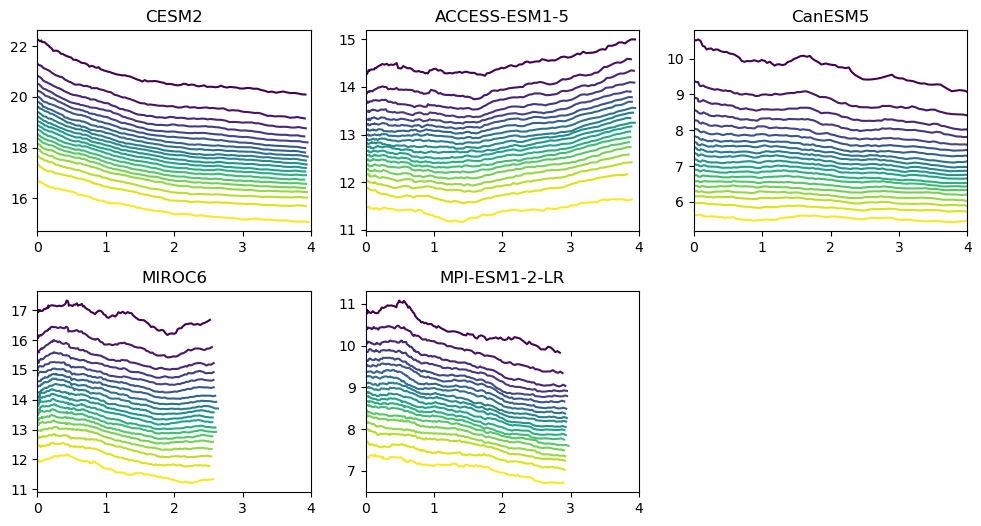

In [11]:
plt.figure(figsize=[12,6])
v='mrsos'
for i,m in enumerate(dsqs):
    dsq=dsqs[m]
    nens=len(dsq.SWquantile)
    avgr=get_avgr(nens,5)
    x=((avgr*dsq['tas_global']).sum(dim='SWquantile')/avgr.sum(dim='SWquantile')).rolling({'year':20},center=True).mean().sel(year=slice(1980,2100))
    y=((avgr*dsq[v]).sum(dim='SWquantile')/avgr.sum(dim='SWquantile')).rolling({'year':20},center=True).mean().sel(year=slice(1980,2100))

    plt.subplot(2,3,i+1)
    for c,xx,yy in zip(colors,x,y):
        plt.plot(xx-xx.sel(year=1980),yy,color=c);
    #plt.ylim([0,80])
    plt.xlim([0,4])
    plt.title(m)
plt.subplots_adjust(hspace=0.3)

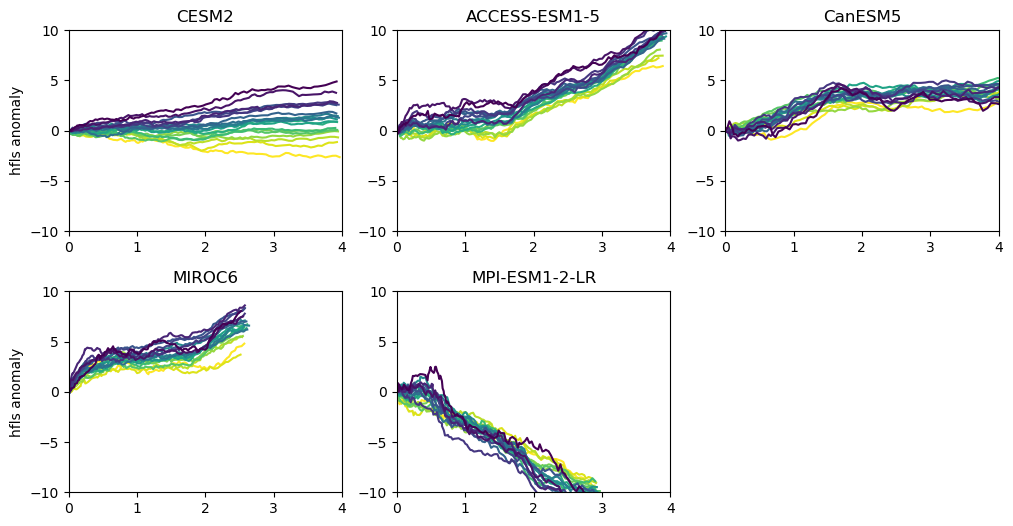

In [16]:
plt.figure(figsize=[12,6])
v='hfls'
for i,m in enumerate(dsqs):
    dsq=dsqs[m]
    nens=len(dsq.SWquantile)
    avgr=get_avgr(nens,5)
    x=((avgr*dsq['tas_global']).sum(dim='SWquantile')/avgr.sum(dim='SWquantile')).rolling({'year':20},center=True).mean().sel(year=slice(1980,2100))
    y=((avgr*dsq[v]).sum(dim='SWquantile')/avgr.sum(dim='SWquantile')).rolling({'year':20},center=True).mean().sel(year=slice(1980,2100))

    plt.subplot(2,3,i+1)
    for c,xx,yy in zip(colors,x,y):
        plt.plot(xx-xx.sel(year=1980),yy-yy.sel(year=1980),color=c);
    plt.xlim([0,4])
    plt.ylim([-10,10])
    plt.title(m)
    if i%3==0:
        plt.ylabel(v+ ' anomaly')
plt.subplots_adjust(hspace=0.3)

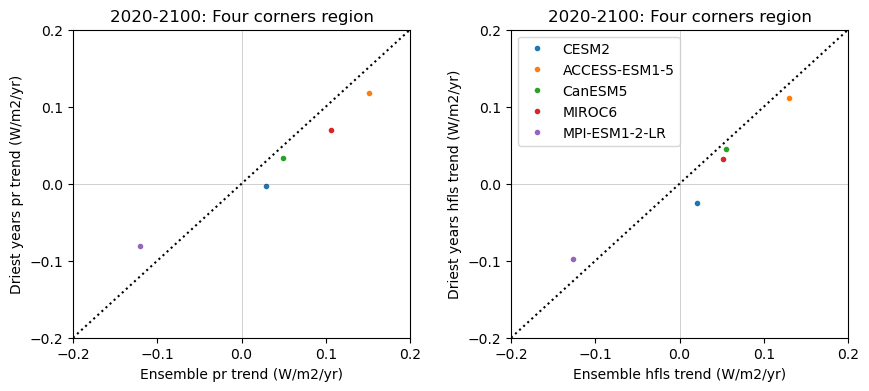

In [86]:
cfs={'hfls':1,'pr':2.5e6}
plt.figure(figsize=[10,4])
for i,v in enumerate(['pr','hfls']):
    plt.subplot(121+i)
    for m in dsqs:
        dsq=dsqs[m]
        nens=len(dsq.SWquantile)
        avgr=get_avgr(nens,5)
        x0=cfs[v]*((avgr*dsq[v]).sum(dim='SWquantile')/avgr.sum(dim='SWquantile')).sel(year=slice(2020,2100))
        p0=x0.isel(perc5=0).polyfit(dim='year',deg=1)
        x=cfs[v]*dsq[v].mean(dim='SWquantile').sel(year=slice(2020,2100))
        p=x.polyfit(dim='year',deg=1)
        
        plt.plot(p.polyfit_coefficients.sel(degree=1),
                 p0.polyfit_coefficients.sel(degree=1),
                 '.',label=m)

    xx=[-0.2,0.2]
    plt.plot(xx,xx,'k:')
    plt.plot(xx,[0,0],'k',lw=0.5,alpha=0.25)
    plt.plot([0,0],xx,'k',lw=0.5,alpha=0.25)
    plt.xlim(xx)
    plt.ylim(xx)
    plt.xticks(np.arange(-0.2,0.3,0.1))

    plt.yticks(np.arange(-0.2,0.3,0.1))
    plt.xlabel('Ensemble '+v+' trend (W/m2/yr)')
    plt.ylabel('Driest years '+v+' trend (W/m2/yr)')
    plt.grid(which='minor')
    plt.title('2020-2100: Four corners region')
plt.legend();
plt.subplots_adjust(wspace=0.3)


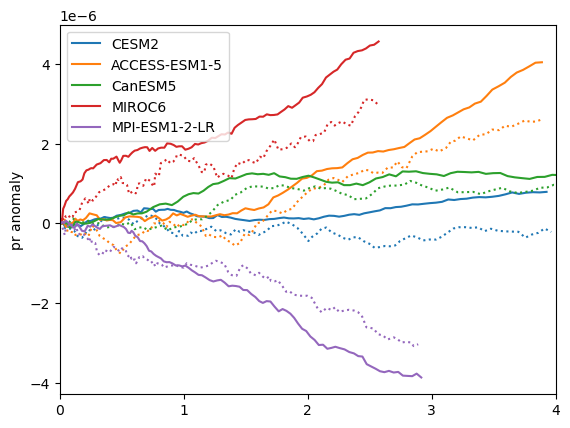

In [176]:
v='pr'
for i,m in enumerate(dsqs):
    dsq=dsqs[m]
    nens=len(dsq.SWquantile)

       
    x=dsq.tas_global.mean(dim='SWquantile').rolling({'year':20},center=True).mean().sel(year=slice(1980,2100))
    y=dsq[v].mean(dim='SWquantile').rolling({'year':20},center=True).mean().sel(year=slice(1980,2100)) 
    plt.plot((x-x.sel(year=1980)),
             (y-y.sel(year=1980)),
             color='C'+str(i),label=m);
    
    avgr=get_avgr(nens,5)
    x=((avgr*dsq['tas_global']).sum(dim='SWquantile')/avgr.sum(dim='SWquantile')).rolling({'year':20},center=True).mean().sel(year=slice(1980,2100))
    y=((avgr*dsq[v]).sum(dim='SWquantile')/avgr.sum(dim='SWquantile')).rolling({'year':20},center=True).mean().sel(year=slice(1980,2100))
    plt.plot((x-x.sel(year=1980)).isel(perc5=0),
             (y-y.sel(year=1980)).isel(perc5=0),
             ':',color='C'+str(i),);
    

plt.legend()
plt.xlim([0,4])
#plt.ylim([-12.5,12.5])
plt.ylabel(v+' anomaly')
plt.xticks(range(5));

In [367]:
def get_slopes(s,p):
    s=s-s.mean(dim='ens')
    s20=xr.concat([s.shift(year=i) for i in range(-10,10)],dim='ens').chunk(dict(ens=-1))
    cf=24*60*60*92
    p20=xr.concat([cf*p.shift(year=i) for i in range(-10,10)],dim='ens')
    q5=np.tile(s20.quantile(0.05,dim='ens').values.reshape([-1,1]),[1,2000])
    ix=(s20<q5).compute()

    x=p20.where(ix).mean(dim='ens').rolling({'year':20}).mean().sel(year=slice(2020,2090))
    lm1=x.polyfit(dim='year',deg=1)
    
    x=(cf*p.mean(dim='ens').rolling({'year':20}).mean()).sel(year=slice(2020,2090))
    lm2=x.polyfit(dim='year',deg=1)

    return lm1.polyfit_coefficients.sel(degree=1).values,lm2.polyfit_coefficients.sel(degree=1).values


(array(-0.02634357), array(0.03166819))

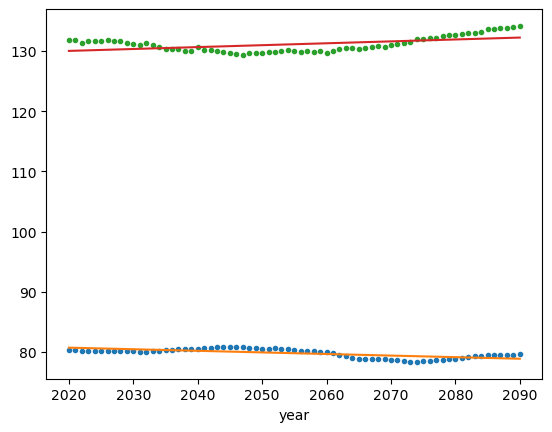

In [366]:
s=ds.SOILWATER_10CM
p=ds.PREC
get_slopes(s,p)

In [401]:
sb=xr.concat([ds.SOILWATER_10CM.shift(year=i) for i in range(-2,3)],dim='block').stack({'bens':['block','ens']}).sel(year=slice(2000,2100)).compute()
pb=xr.concat([ds.PREC.shift(year=i) for i in range(-2,3)],dim='block').stack({'bens':['block','ens']}).sel(year=slice(2000,2100)).compute()

In [398]:
def boots(sb,pb):
    rands=np.random.randint(500,size=[len(sb.year),100])
    x=xr.DataArray([s.isel(bens=r).values for s,r in zip(sb,rands)],
                  coords=[sb.year,ds.ens])
    y=xr.DataArray([s.isel(bens=r).values for s,r in zip(pb,rands)],
                  coords=[sb.year,ds.ens])
    d,f=get_slopes(x,y)
    return (d,f)
    
    

In [400]:
[boots(sb,pb.sel(year=slice(2000,2100))) for i in range(10)]

[(array(0.03385775), array(0.03090931)),
 (array(0.02675013), array(0.03110292)),
 (array(-0.00913017), array(0.01851585)),
 (array(-0.06146293), array(0.02391081)),
 (array(-0.07356739), array(0.00400642)),
 (array(-0.07258072), array(0.03622748)),
 (array(-0.09242379), array(0.00419531)),
 (array(-0.06316146), array(0.02815692)),
 (array(-0.03038235), array(0.01182249)),
 (array(-0.0293321), array(0.05053452))]

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 50 concurrent workers.


[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:   18.4s


[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 350 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 700 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   56.6s finished


In [409]:
drys=[r[0] for r in results]
fulls=[r[1] for r in results]

(array([ 0.98545861,  5.51856822,  9.75604024, 21.08881426, 24.73501112,
        21.77863529, 11.03713644,  2.95637583,  0.59127517,  0.09854586]),
 array([-0.01334224, -0.00319468,  0.00695288,  0.01710044,  0.027248  ,
         0.03739556,  0.04754312,  0.05769068,  0.06783823,  0.07798579,
         0.08813335]),
 <BarContainer object of 10 artists>)

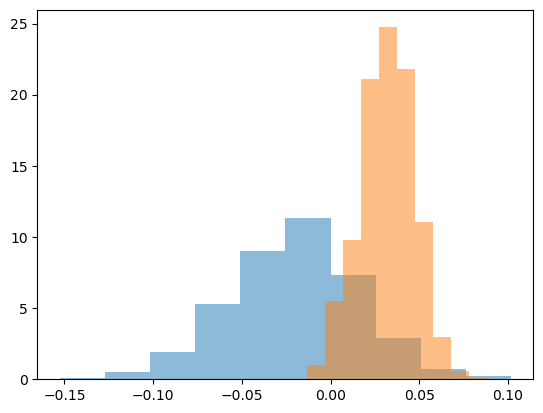

In [412]:
plt.hist(drys,alpha=0.5,density=True)
plt.hist(fulls,alpha=0.5,density=True)

In [439]:


rands=np.random.randint(100,size=[100,len(yrs)])
x=xr.concat([xr.DataArray(np.concatenate([ds.SOILWATER_10CM.sel(year=slice(yr,yr+4),ens=r).values for yr,r in zip(yrs,rs)]),
          coords={'year':np.arange(yr0,2101)}) for rs in rands],dim='ens')
y=xr.concat([xr.DataArray(np.concatenate([ds.PREC.sel(year=slice(yr,yr+4),ens=r).values for yr,r in zip(yrs,rs)]),
          coords={'year':np.arange(yr0,2101)}) for rs in rands],dim='ens')

In [467]:
1000/50

20.0

In [475]:
def boots(yr0):
    drys=[]
    fulls=[]
    yrs=range(yr0,2101,5)
    for i in range(10):
        r=np.random.randint(100,size=100)
        x=xr.concat([xr.DataArray(ds.SOILWATER_10CM.sel(year=slice(yr,yr+4)).isel(ens=r).values,
                    coords=[ds.year.sel(year=slice(yr,yr+4)),ds.ens]) for yr in yrs],dim='year')
        y=xr.concat([xr.DataArray(ds.PREC.sel(year=slice(yr,yr+4)).isel(ens=r).values,
                    coords=[ds.year.sel(year=slice(yr,yr+4)),ds.ens]) for yr in yrs],dim='year')
        d,f=get_slopes(x,y)
        drys.append(d)
        fulls.append(f)
    return (drys,fulls)

In [494]:
with joblib.parallel_config(backend="dask"):
    results=Parallel(verbose=1)(delayed(boots)(yr0) for yr0 in yrs)

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 50 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.0min finished


In [491]:
np.concatenate([r[0] for r in results]).shape

(500,)

(array([ 0.10111729,  1.61787661,  5.25809899, 17.49329086, 27.60501968,
        26.89719867, 14.35865493,  6.16815458,  1.31452475,  0.30335186]),
 array([-0.01694267, -0.00705316,  0.00283634,  0.01272585,  0.02261536,
         0.03250486,  0.04239437,  0.05228387,  0.06217338,  0.07206288,
         0.08195239]),
 <BarContainer object of 10 artists>)

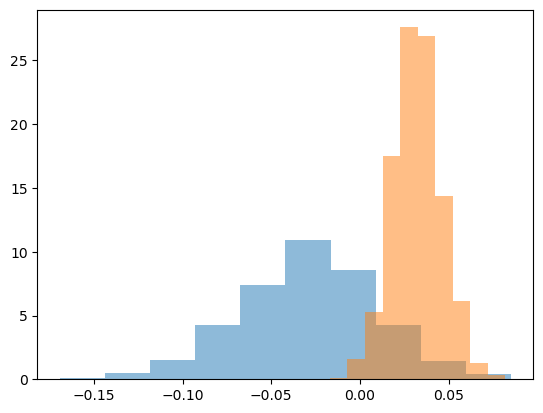

In [501]:
plt.hist(np.concatenate([r[0] for r in results]),density=True,alpha=0.5)
plt.hist(np.concatenate([r[1] for r in results]),density=True,alpha=0.5)


In [498]:
get_slopes(ds.SOILWATER_10CM,ds.PREC)

(array(-0.02634357), array(0.03166819))

In [493]:
yrs=(1990+np.floor(np.arange(100)/20)).astype(int)
yrs

array([1990, 1990, 1990, 1990, 1990, 1990, 1990, 1990, 1990, 1990, 1990,
       1990, 1990, 1990, 1990, 1990, 1990, 1990, 1990, 1990, 1991, 1991,
       1991, 1991, 1991, 1991, 1991, 1991, 1991, 1991, 1991, 1991, 1991,
       1991, 1991, 1991, 1991, 1991, 1991, 1991, 1992, 1992, 1992, 1992,
       1992, 1992, 1992, 1992, 1992, 1992, 1992, 1992, 1992, 1992, 1992,
       1992, 1992, 1992, 1992, 1992, 1993, 1993, 1993, 1993, 1993, 1993,
       1993, 1993, 1993, 1993, 1993, 1993, 1993, 1993, 1993, 1993, 1993,
       1993, 1993, 1993, 1994, 1994, 1994, 1994, 1994, 1994, 1994, 1994,
       1994, 1994, 1994, 1994, 1994, 1994, 1994, 1994, 1994, 1994, 1994,
       1994])

In [375]:
for i in range(9):
    rands=np.random.randint(500,size=[251,100])

    drys.append(d)
    fulls.append(f)

(array([1., 0., 0., 0., 0., 0., 1., 4., 2., 2.]),
 array([-0.00886502, -0.00448339, -0.00010175,  0.00427988,  0.00866151,
         0.01304315,  0.01742478,  0.02180642,  0.02618805,  0.03056968,
         0.03495132]),
 <BarContainer object of 10 artists>)

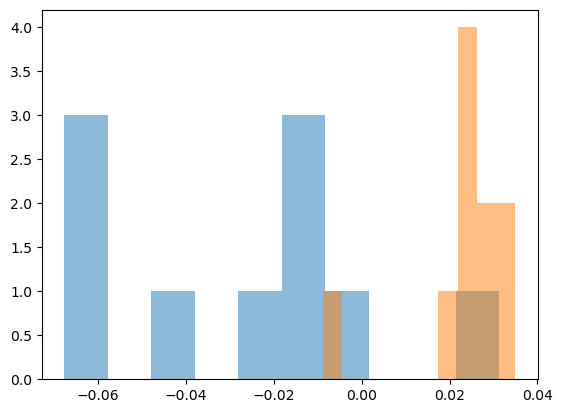

In [377]:
plt.hist(drys,alpha=0.5)
plt.hist(fulls,alpha=0.5)

In [373]:
drys=[]
fulls=[]

In [322]:
bootstrap=np.random.randint(500)

In [281]:
aa=lm.polyfit_coefficients.sel(degree=1).values

In [282]:
s=ds.SOILWATER_10CM
ix=(s<np.tile(s.quantile(0.05,dim='ens').values.reshape([-1,1]),[1,100])).compute()

(78.0, 82.0)

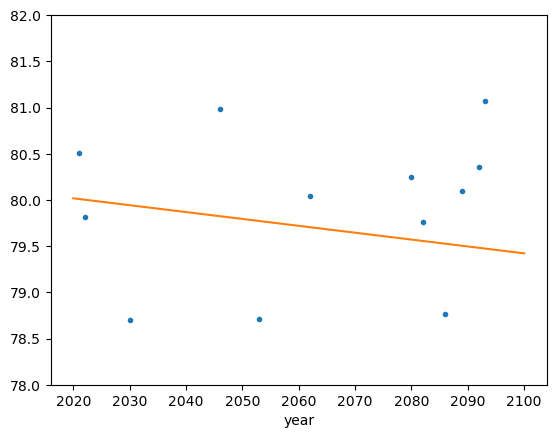

In [283]:
x=cf*ds.PREC.where(ix).mean(dim='ens').sel(year=slice(2020,2100))
x.plot.line('.')
lm=x.polyfit(dim='year',deg=1)
xr.polyval(x.year,lm.polyfit_coefficients).plot()
plt.ylim([78,82])

In [284]:
bb=lm.polyfit_coefficients.sel(degree=1).values

In [285]:
aa

array(-0.02634357)

In [286]:
bb

array(-0.00744671)

In [287]:
aa/bb

3.5376109866080157

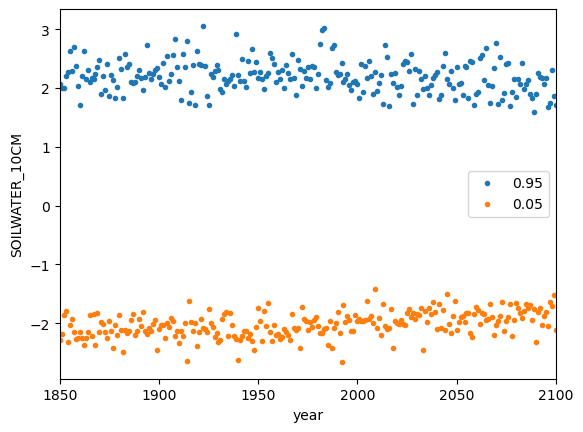

In [220]:
s.quantile(0.95,dim='ens').plot.line('.',label=0.95)
s.quantile(0.05,dim='ens').plot.line('.',label=0.05)
plt.xlim([1850,2100])
plt.title('')
plt.legend()

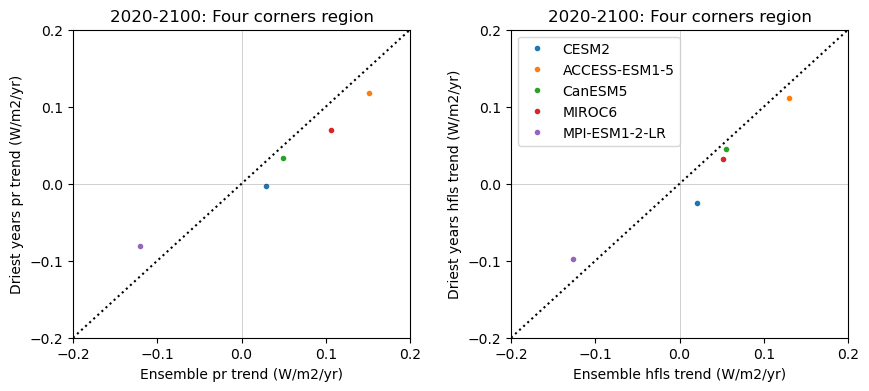

In [86]:
cfs={'hfls':1,'pr':2.5e6}
plt.figure(figsize=[10,4])
for i,v in enumerate(['pr','hfls']):
    plt.subplot(121+i)
    for m in dsqs:
        dsq=dsqs[m]
        nens=len(dsq.SWquantile)
        avgr=get_avgr(nens,5)
        x0=cfs[v]*((avgr*dsq[v]).sum(dim='SWquantile')/avgr.sum(dim='SWquantile')).sel(year=slice(2020,2100))
        p0=x0.isel(perc5=0).polyfit(dim='year',deg=1)
        x=cfs[v]*dsq[v].mean(dim='SWquantile').sel(year=slice(2020,2100))
        p=x.polyfit(dim='year',deg=1)
        
        plt.plot(p.polyfit_coefficients.sel(degree=1),
                 p0.polyfit_coefficients.sel(degree=1),
                 '.',label=m)

    xx=[-0.2,0.2]
    plt.plot(xx,xx,'k:')
    plt.plot(xx,[0,0],'k',lw=0.5,alpha=0.25)
    plt.plot([0,0],xx,'k',lw=0.5,alpha=0.25)
    plt.xlim(xx)
    plt.ylim(xx)
    plt.xticks(np.arange(-0.2,0.3,0.1))

    plt.yticks(np.arange(-0.2,0.3,0.1))
    plt.xlabel('Ensemble '+v+' trend (W/m2/yr)')
    plt.ylabel('Driest years '+v+' trend (W/m2/yr)')
    plt.grid(which='minor')
    plt.title('2020-2100: Four corners region')
plt.legend();
plt.subplots_adjust(wspace=0.3)


 
pr
------
CESM2            -8.0
ACCESS-ESM1-5    -8.7
CanESM5          -3.9
MIROC6           -9.6
MPI-ESM1-2-LR    10.2
 
hfls
------
CESM2            -11.7
ACCESS-ESM1-5    -4.8
CanESM5          -2.6
MIROC6           -5.0
MPI-ESM1-2-LR    7.4


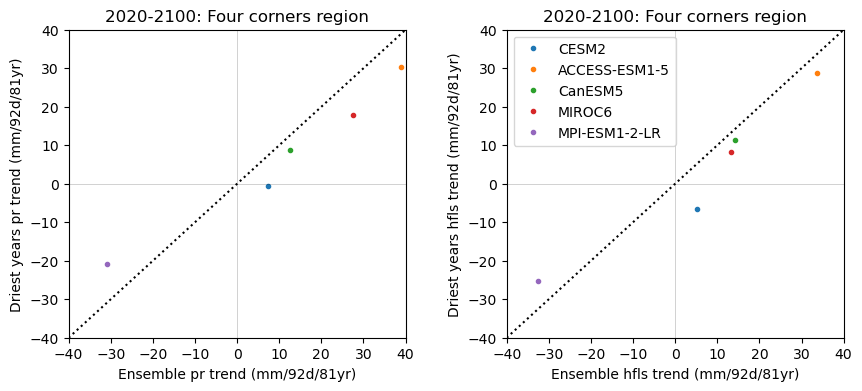

In [106]:
cfs={'hfls':24*60*60*92*81/2.5e6,'pr':24*60*60*92*81}
plt.figure(figsize=[10,4])
for i,v in enumerate(['pr','hfls']):
    print(' ')
    print(v)
    print('------')
    plt.subplot(121+i)
    for m in dsqs:
        dsq=dsqs[m]
        nens=len(dsq.SWquantile)
        avgr=get_avgr(nens,5)
        x0=cfs[v]*((avgr*dsq[v]).sum(dim='SWquantile')/avgr.sum(dim='SWquantile')).sel(year=slice(2020,2100))
        p0=x0.isel(perc5=0).polyfit(dim='year',deg=1)
        x=cfs[v]*dsq[v].mean(dim='SWquantile').sel(year=slice(2020,2100))
        p=x.polyfit(dim='year',deg=1)
        
        plt.plot(p.polyfit_coefficients.sel(degree=1),
                 p0.polyfit_coefficients.sel(degree=1),
                 '.',label=m)

        print(m.ljust(16),np.round(p0.polyfit_coefficients.sel(degree=1)-p.polyfit_coefficients.sel(degree=1),1).values)
    
    xx=[-40,40]
    plt.plot(xx,xx,'k:')
    plt.plot(xx,[0,0],'k',lw=0.5,alpha=0.25)
    plt.plot([0,0],xx,'k',lw=0.5,alpha=0.25)
    plt.xlim(xx)
    plt.ylim(xx)
    #plt.xticks(np.arange(-0.2,0.3,0.1))
    #plt.yticks(np.arange(-0.2,0.3,0.1))
    plt.xlabel('Ensemble '+v+' trend (mm/92d/81yr)')
    plt.ylabel('Driest years '+v+' trend (mm/92d/81yr)')
    plt.grid(which='minor')
    plt.title('2020-2100: Four corners region')
plt.legend();
plt.subplots_adjust(wspace=0.3)


In [107]:
#reading data
d='/glade/derecho/scratch/djk2120/postp/jas/'
dvs=['SOILWATER_10CM','TREFHT_global','PREC','ET']
ds=xr.Dataset()
for v in dvs:
    files=sorted(glob.glob(d+v+'*.nc'))
    ds[v]=xr.open_mfdataset(files,combine='by_coords')[v]



In [147]:
import warnings
warnings.filterwarnings('ignore')

In [174]:
ps=[]
yr=2020
r=np.random.randint(100,size=100)
s=ds.SOILWATER_10CM.sel(year=yr).isel(ens=r).compute()
p=ds.PREC.sel(year=yr).isel(ens=r).compute()
ix=np.argsort(s)[:5]
s[ix]



<xarray.DataArray 'SOILWATER_10CM' (ens: 5)>
array([15.56600362, 15.7716125 , 15.7716125 , 15.93215904, 16.04157752])
Coordinates:
    year     int64 2020
Dimensions without coordinates: ens

In [169]:
[yr for yr in range(2020,2100)]

[2020,
 2021,
 2022,
 2023,
 2024,
 2025,
 2026,
 2027,
 2028,
 2029,
 2030,
 2031,
 2032,
 2033,
 2034,
 2035,
 2036,
 2037,
 2038,
 2039,
 2040,
 2041,
 2042,
 2043,
 2044,
 2045,
 2046,
 2047,
 2048,
 2049,
 2050,
 2051,
 2052,
 2053,
 2054,
 2055,
 2056,
 2057,
 2058,
 2059,
 2060,
 2061,
 2062,
 2063,
 2064,
 2065,
 2066,
 2067,
 2068,
 2069,
 2070,
 2071,
 2072,
 2073,
 2074,
 2075,
 2076,
 2077,
 2078,
 2079,
 2080,
 2081,
 2082,
 2083,
 2084,
 2085,
 2086,
 2087,
 2088,
 2089,
 2090,
 2091,
 2092,
 2093,
 2094,
 2095,
 2096,
 2097,
 2098,
 2099]

In [168]:
np.concatenate(ps).shape

(445,)

In [165]:
81*5

405

In [75]:
nens=len(dsq.SWquantile)




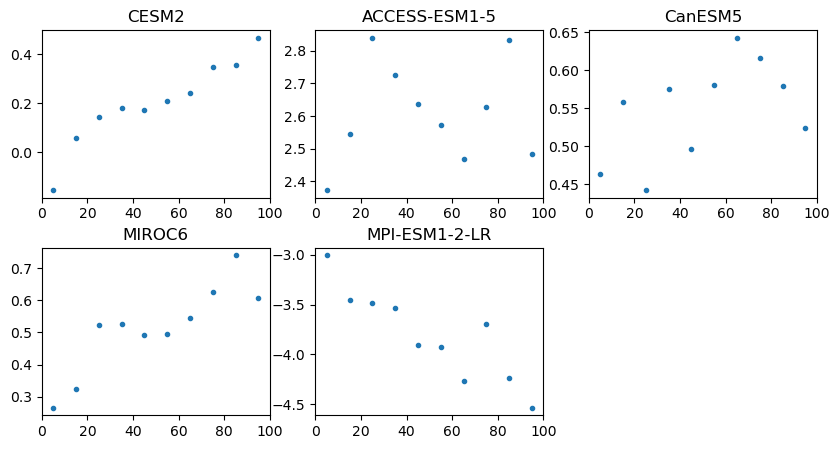

In [96]:
q=10
v='hfls'
plt.figure(figsize=[10,5])
for i,m in enumerate(dsqs):
    plt.subplot(2,3,i+1)
    dsq=dsqs[m]
    nens=len(dsq.SWquantile)
    avgr=get_avgr(nens,q)
    pf=(avgr*dsq[v]).sum(dim='SWquantile').sel(year=slice(2020,2100)).polyfit(dim='year',deg=1)
    plt.plot(q/2+np.arange(0,100,q),pf.polyfit_coefficients.sel(degree=1),'.')
    plt.xlim([0,100])
    plt.title(m)

plt.subplots_adjust(hspace=0.3)

array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
       85, 90, 95])

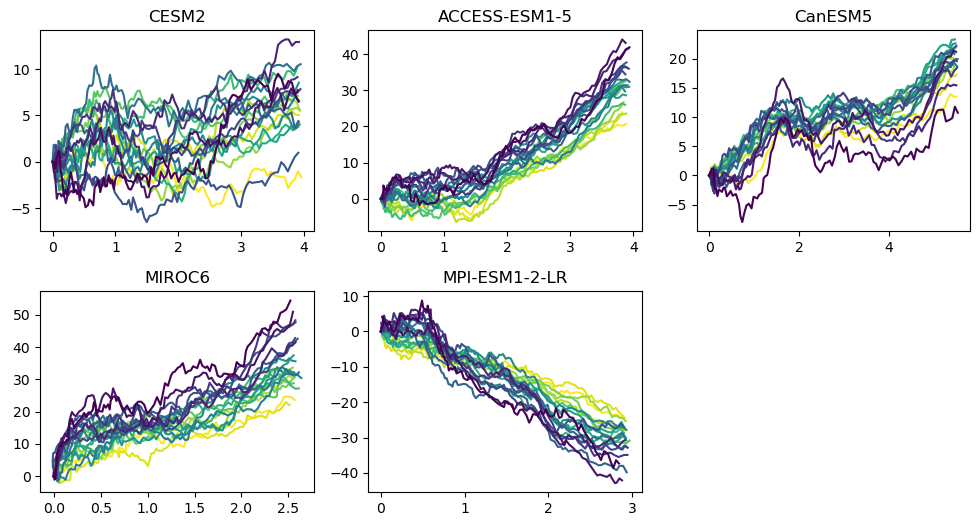

In [108]:
plt.figure(figsize=[12,6])
for i,m in enumerate(xs):
    x=xs[m]
    y=ys[m]
    plt.subplot(2,3,i+1)
    for t,p,c in zip(x,y,colors):
        plt.plot((t-t.sel(year=1980)).sel(year=slice(1980,2100)),
                 (p-p.sel(year=1980)).sel(year=slice(1980,2100)),color=c)
    plt.title(m)
    plt.subplots_adjust(hspace=0.3)

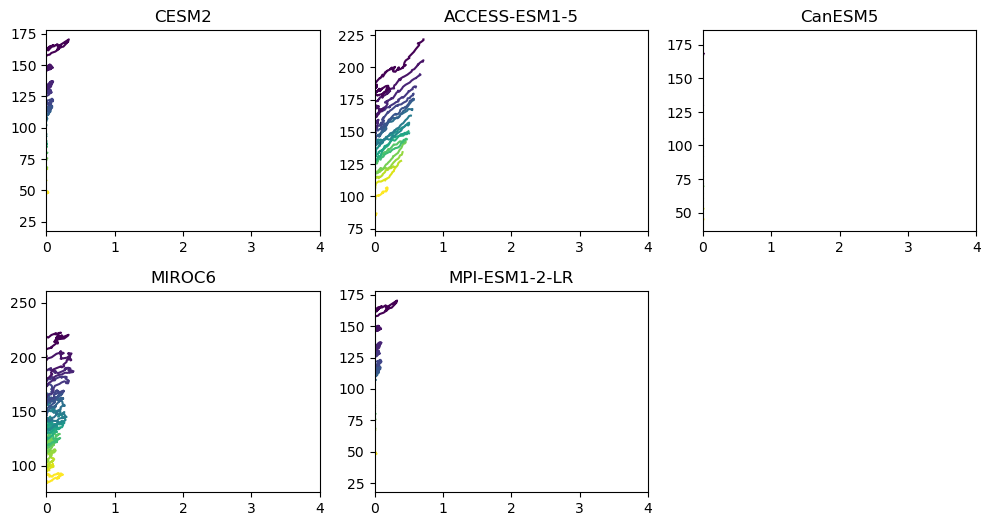

In [115]:
plt.figure(figsize=[12,6])
for i,m in enumerate(xs):
    x=xs[m]
    y=ys[m]
    plt.subplot(2,3,i+1)
    for t,p,c in zip(x,y,colors):
        plt.plot((t-t.sel(year=1980)).sel(year=slice(1980,2100)),
                 (p).sel(year=slice(1980,2100)),color=c)
    plt.title(m)
    plt.subplots_adjust(hspace=0.3)
    #plt.ylim([0,250])
    plt.xlim([0,4])

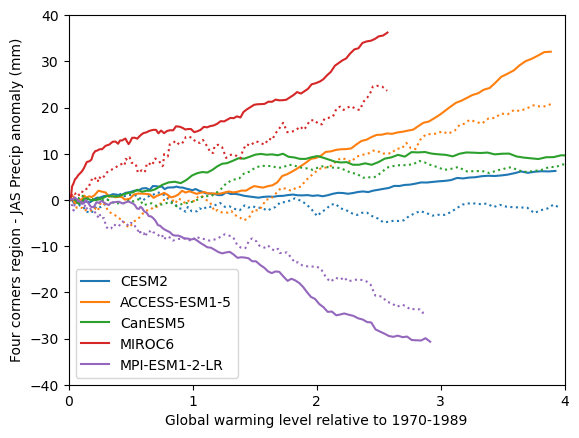

In [112]:
for i,m in enumerate(dsqs):
    dsq=dsqs[m]
    t=dsq.tas_global.mean(dim='SWquantile').rolling({'year':20},center=True).mean().sel(year=slice(1980,2100))
    p=cf*dsq.pr.mean(dim='SWquantile').rolling({'year':20},center=True).mean().sel(year=slice(1980,2100))
    plt.plot(t-t.sel(year=1980),p-p.sel(year=1980),label=m,color='C'+str(i))

    x=xs[m][0,:].sel(year=slice(1980,2100))
    y=ys[m][0,:].sel(year=slice(1980,2100))

    plt.plot(x-x.sel(year=1980),y-y.sel(year=1980),':',color='C'+str(i))

plt.legend()
plt.xlabel('Global warming level relative to 1970-1989')
plt.ylabel('Four corners region - JAS Precip anomaly (mm)')
plt.xlim([0,4])
plt.ylim([-40,40])
plt.xticks(range(5));

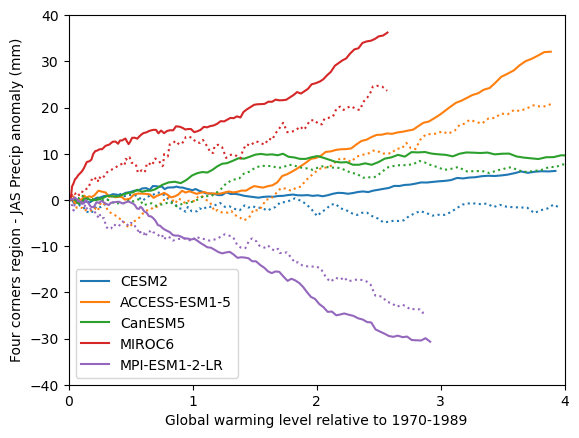

In [112]:
for i,m in enumerate(dsqs):
    dsq=dsqs[m]
    t=dsq.tas_global.mean(dim='SWquantile').rolling({'year':20},center=True).mean().sel(year=slice(1980,2100))
    p=cf*dsq.pr.mean(dim='SWquantile').rolling({'year':20},center=True).mean().sel(year=slice(1980,2100))
    plt.plot(t-t.sel(year=1980),p-p.sel(year=1980),label=m,color='C'+str(i))

    x=xs[m][0,:].sel(year=slice(1980,2100))
    y=ys[m][0,:].sel(year=slice(1980,2100))

    plt.plot(x-x.sel(year=1980),y-y.sel(year=1980),':',color='C'+str(i))

plt.legend()
plt.xlabel('Global warming level relative to 1970-1989')
plt.ylabel('Four corners region - JAS Precip anomaly (mm)')
plt.xlim([0,4])
plt.ylim([-40,40])
plt.xticks(range(5));

In [10]:
cf=24*60*60*92

In [70]:
qqs

<xarray.DataArray (a: 200)>
array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  5.,  5.,
        5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  6.,  6.,  6.,  6.,  6.,
        6.,  6.,  6.,  6.,  6.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
        7.,  7.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  9.,
        9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 11., 11., 11., 11., 11., 11., 11.,
       11., 11., 11., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
       13., 13., 13., 13., 13., 13., 13., 13., 13., 13., 14., 14., 14.,
       14., 14., 14., 14., 14., 14., 14., 15., 15., 15., 15., 15., 15.,
       15., 15., 15., 15., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 18., 18.,
       18., 18., 18., 18., 18., 18., 18., 18., 19., 19., 19., 19., 19.,
       19., 19., 19., 19., 19.])
Dimensions without coordinates: a

In [61]:
nens=50
wts=np.zeros(nens)+100/nens
q=5
avgs=[]
go=True
ct=0
while go:
    ct+=1
    a=np.zeros(nens)
    for i in range(nens):
        if wts[i]>0:
            
    if ct>10:
        go=False
        

In [55]:
np.arange(100)*0.4

array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ,
        4.4,  4.8,  5.2,  5.6,  6. ,  6.4,  6.8,  7.2,  7.6,  8. ,  8.4,
        8.8,  9.2,  9.6, 10. , 10.4, 10.8, 11.2, 11.6, 12. , 12.4, 12.8,
       13.2, 13.6, 14. , 14.4, 14.8, 15.2, 15.6, 16. , 16.4, 16.8, 17.2,
       17.6, 18. , 18.4, 18.8, 19.2, 19.6, 20. , 20.4, 20.8, 21.2, 21.6,
       22. , 22.4, 22.8, 23.2, 23.6, 24. , 24.4, 24.8, 25.2, 25.6, 26. ,
       26.4, 26.8, 27.2, 27.6, 28. , 28.4, 28.8, 29.2, 29.6, 30. , 30.4,
       30.8, 31.2, 31.6, 32. , 32.4, 32.8, 33.2, 33.6, 34. , 34.4, 34.8,
       35.2, 35.6, 36. , 36.4, 36.8, 37.2, 37.6, 38. , 38.4, 38.8, 39.2,
       39.6])

In [16]:
s=xr.concat(ss,dim='year')

In [18]:
s.isel(year=0)

<xarray.DataArray 'mrsos' (ens: 50)>
array([14.884889  , 13.5698721 , 12.35282019, 15.12371354, 15.42828912,
       12.33824521, 12.57442928, 14.13774138, 13.02086958, 16.73323076,
       13.67982543, 16.83347532, 15.06560617, 14.44249025, 15.82130863,
       14.5357913 , 14.91614225, 14.0447071 , 14.65867997, 14.91744596,
       14.38619681, 14.47041425, 15.4231458 , 16.64764892, 14.68644747,
       14.96782123, 14.76388806, 14.00404566, 15.12704989, 15.58858847,
       15.39747903, 14.93857322, 13.44317919, 13.68138314, 13.23450129,
       15.54837961, 14.45454782, 16.37808193, 16.7857237 , 14.9290845 ,
       13.88954349, 13.02066462, 15.23629926, 15.60609164, 13.38594351,
       14.10014248, 17.14700486, 14.43296953, 14.91307223, 12.83566853])
Coordinates:
  * ens      (ens) <U9 'r10i1p1f1' 'r11i1p1f1' ... 'r8i1p1f1' 'r9i1p1f1'
    depth    float64 0.05
    year     int64 1850
    height   float64 2.0

In [133]:
#read in the data
d='/glade/derecho/scratch/djk2120/postp/jas/'
dvs=['PREC','ET','SOILWATER_10CM','TSA','TREFHT_global']
ds=xr.Dataset()
for v in dvs:
    files=sorted(glob.glob(d+v+'*.nc'))
    ds[v]=xr.open_mfdataset(files,combine='by_coords')[v]

In [180]:
#stratify by soil moisture quantile
dvs=['PREC','ET','TREFHT_global']
quantiles={v:{} for v in dvs}
sw=ds.SOILWATER_10CM
nx=25
qqs=np.linspace(0,1,nx+1)
for q1,q2 in zip(qqs[:-1],qqs[1:]):
    ix=((sw>=sw.quantile(q1,dim='ens'))&
        (sw<=sw.quantile(q2,dim='ens')))
    for v in dvs:
        x=ds[v].where(ix).mean(dim='ens').rolling({'year':20}).mean()
        quantiles[v][q1]=x-x.sel(year=1980)

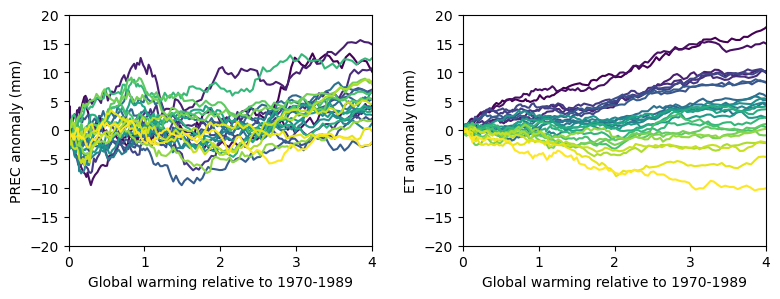

In [197]:
#plot
cf=24*60*60*92
colors=cm.viridis(np.linspace(0,1,25))
plt.figure(figsize=[9,3])
for i,v in enumerate(['PREC','ET']):
    plt.subplot(121+i)
    for q,c in zip(np.flipud(qqs[:-1]),colors):
        plt.plot(quantiles['TREFHT_global'][q].sel(year=slice(1980,2100)),
                 cf*quantiles[v][q].sel(year=slice(1980,2100)),
                 color=c)
    plt.xlabel('Global warming relative to 1970-1989')
    plt.ylabel(v+' anomaly (mm)')
    plt.xlim([0, 4])
    plt.ylim([-20, 20])
    #plt.legend()
plt.subplots_adjust(wspace=0.3)

In [198]:
#read in the data
files=sorted(glob.glob('/glade/derecho/scratch/djk2120/postp/cmip/*.nc'))
ds=xr.open_mfdataset(files,combine='nested',concat_dim='ens')
ds['et']=ds['evspsblsoi']+ds['evspsblveg']+ds['tran']
ds=ds.chunk(dict(ens=-1))

In [199]:
#stratify by soil moisture decile
dvs=['pr','et','tas_global']
quantiles={v:{} for v in dvs}
sw=ds.mrsos
nx=25
qqs=np.linspace(0,1,nx+1)
for q1,q2 in zip(qqs[:-1],qqs[1:]):
    ix=((sw>=sw.quantile(q1,dim='ens'))&
        (sw<=sw.quantile(q2,dim='ens')))
    for v in dvs:
        x=ds[v].where(ix).mean(dim='ens').rolling({'year':20}).mean()
        quantiles[v][q1]=x-x.sel(year=1980)

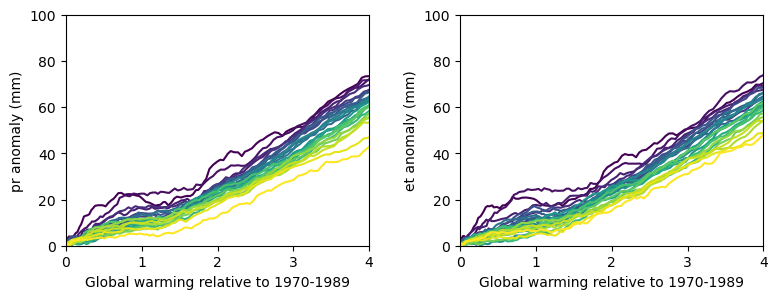

In [201]:
#plot
cf=24*60*60*92
colors=cm.viridis(np.linspace(0,1,25))
plt.figure(figsize=[9,3])
for i,v in enumerate(['pr','et']):
    plt.subplot(121+i)
    for q,c in zip(np.flipud(qqs[:-1]),colors):
        plt.plot(quantiles['tas_global'][q].sel(year=slice(1980,2100)),
                 cf*quantiles[v][q].sel(year=slice(1980,2100)),
                 color=c)
    plt.xlabel('Global warming relative to 1970-1989')
    plt.ylabel(v+' anomaly (mm)')
    plt.xlim([0, 4])
    plt.ylim([0, 100])
    #plt.legend()
plt.subplots_adjust(wspace=0.3)

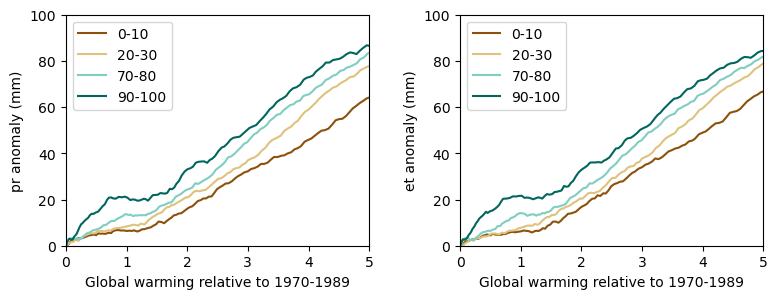

In [131]:
#plot
cf=24*60*60*92
colors=['#8c510a','#dfc27d','#80cdc1','#01665e']
plt.figure(figsize=[9,3])
for i,v in enumerate(['pr','et']):
    plt.subplot(121+i)
    for d,c in zip([0,2,7,9],colors):
        plt.plot(deciles['tas_global'][d],
                 cf*deciles[v][d],
                 color=c,label=str(d*10)+'-'+str(10+d*10))
    plt.xlabel('Global warming relative to 1970-1989')
    plt.ylabel(v+' anomaly (mm)')
    plt.xlim([0, 5])
    plt.ylim([0, 100])
    plt.legend()
plt.subplots_adjust(wspace=0.3)